In [70]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import cv2
#from dataloader import LoadDataset
from torch.utils.data import Dataset, DataLoader
import sklearn
import sklearn.metrics

plt.ion()   # interactive mode

In [30]:
TONGJI = False

if TONGJI:
    data_dir = 'datasets_tongji/'
else:
    data_dir = 'datasets/'

num_epochs = 10
batch_size = 4

learning_algorithm = models.resnet18

In [31]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        #transforms.CenterCrop(24),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'datasets/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#print(len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

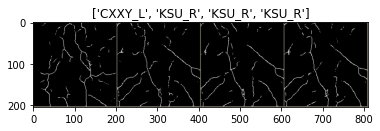

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [45]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.set_title(f"predicted: {class_names[preds[j]]} source: {class_names[labels[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [35]:
model_ft = learning_algorithm(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

print("Classes: ", {len(class_names)})

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Classes:  {4}


In [36]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.4483 Acc: 0.8450
val Loss: 0.7671 Acc: 0.7050

Epoch 1/9
----------
train Loss: 0.0804 Acc: 0.9800
val Loss: 0.4203 Acc: 0.8400

Epoch 2/9
----------
train Loss: 0.1106 Acc: 0.9600
val Loss: 0.7696 Acc: 0.7050

Epoch 3/9
----------
train Loss: 0.0184 Acc: 0.9975
val Loss: 1.0509 Acc: 0.5850

Epoch 4/9
----------
train Loss: 0.0082 Acc: 1.0000
val Loss: 0.5128 Acc: 0.7850

Epoch 5/9
----------
train Loss: 0.0107 Acc: 1.0000
val Loss: 1.0675 Acc: 0.6700

Epoch 6/9
----------
train Loss: 0.0086 Acc: 1.0000
val Loss: 0.8502 Acc: 0.7250

Epoch 7/9
----------
train Loss: 0.0673 Acc: 0.9750
val Loss: 0.3528 Acc: 0.8600

Epoch 8/9
----------
train Loss: 0.0238 Acc: 0.9925
val Loss: 0.9444 Acc: 0.6950

Epoch 9/9
----------
train Loss: 0.0630 Acc: 0.9800
val Loss: 1.0242 Acc: 0.7000

Training complete in 5m 32s
Best val Acc: 0.860000


In [59]:
def test_model_accuracy(model, test_data, classes_pool):
    import torchmetrics

    metric = torchmetrics.Accuracy()

    with torch.no_grad():
        for data in test_data:

            images, y_targets = data # y_targets = labels
            outputs = model(images)
            _, y_preds = torch.max(outputs.data, 1)

            y_true = y_targets.numpy()
            y_pred = y_preds.numpy()

            #print(y_true, ' - ', y_pred)

            for outdata in list(zip(y_preds, y_targets)):
                print(f'Source: {class_names[outdata[1]]}; '
                      f'Predict: {class_names[outdata[0]]}; ')


    acc = metric.compute()
    print(f"Accuracy on test images = {acc}")

test_model_accuracy(model_ft,
                    dataloaders["val"],
                    class_names)

Source: CXXY_L; Predict: CXXY_L; Accuracy on batch 0.75
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 0.75
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 0.75
Source: CXXY_R; Predict: KSU_L; Accuracy on batch 0.75
Source: CXXY_R; Predict: KSU_L; Accuracy on batch 0.75
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 0.75
Source: CXXY_L; Predict: CXXY_L; Accuracy on batch 0.75
Source: CXXY_L; Predict: CXXY_L; Accuracy on batch 0.75
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 0.75
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 0.75
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 0.75
Source: CXXY_R; Predict: KSU_L; Accuracy on batch 0.75
Source: CXXY_L; Predict: CXXY_L; Accuracy on batch 1.0
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 1.0
Source: CXXY_L; Predict: CXXY_L; Accuracy on batch 1.0
Source: CXXY_R; Predict: CXXY_R; Accuracy on batch 1.0
Source: CXXY_L; Predict: CXXY_L; Accuracy on batch 0.5
Source: CXXY_R; Predict: KSU_L; Accuracy on batch 0.5
So

In [71]:
class LoadDataset(Dataset):
    def __init__(self, ds_path,):
        self.files = glob.glob(ds_path, recursive=True)

    def __getitem__(self, index):
        im, us, fi = self.pull_item(index)
        return im, us, fi

    def __len__(self):
        return len(self.files)

    def pull_item(self, index):
        to_tensor = transforms.ToTensor()
        img_path = self.files[index]
        user = img_path.split("\\")[-2]
        file = img_path.split("\\")[-1]
        image = cv2.imread(img_path)
        return to_tensor(image), user, file

In [75]:
users = os.listdir(f"./{data_dir}val")
feats_arr = dict(zip(users, [[] for x in range(len(class_names))]))

ds_path = f"./{data_dir}val/*/**.jpg"
feats_path = "./feats/"
dataset = LoadDataset(ds_path)

print(len(dataset))
for sample, user, file in dataset:
    with torch.no_grad():
        feats = model_ft.feature_extractor(sample.unsqueeze(0))
        feats = feats.data.numpy()[0]
        save_path = os.path.join(feats_path, user)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        feats_arr[user].append(feats )
        np.save(os.path.join(save_path, file), feats)

feats_arr

200


{'CXXY_L': [array([0.00000000e+00, 2.99355239e-01, 1.09708244e-02, 1.54251909e+00,
         4.31684777e-02, 2.69599050e-01, 9.80646000e-04, 5.94798417e-04,
         1.34319007e+00, 8.72216523e-02, 0.00000000e+00, 6.67055091e-03,
         2.60252142e+00, 3.95794660e-01, 0.00000000e+00, 7.42992200e-03,
         1.23152578e+00, 2.49791479e+00, 8.97440255e-01, 1.08834833e-01,
         0.00000000e+00, 0.00000000e+00, 3.51460397e-01, 1.88137386e-02,
         9.70570520e-02, 4.81876358e-02, 0.00000000e+00, 4.61706566e-03,
         2.08446354e-01, 2.14114398e-01, 8.43822062e-01, 5.24544954e-01,
         2.04514802e-01, 0.00000000e+00, 2.47271672e-01, 3.88154238e-01,
         1.62308609e+00, 1.19665310e-01, 1.06927824e+00, 2.07912680e-02,
         0.00000000e+00, 1.05008386e-01, 0.00000000e+00, 7.86268190e-02,
         7.77934849e-01, 0.00000000e+00, 4.84204352e-01, 3.22386336e+00,
         0.00000000e+00, 5.86408257e-01, 9.90270138e-01, 4.38184738e-01,
         3.45896542e-01, 4.02072631e-02, 

In [ ]:
if os.path.exists("s1.txt"):
    os.remove("s1.txt")

for user in feats_arr:
    dists_one = sklearn.metrics.pairwise_distances(np.array(feats_arr[user]))
    dists_one = dists_one[dists_one != 0].tolist()

    with open("s1.txt", "a") as f:
        for val in dists_one:
            f.write(str(val)+'\n')

In [ ]:
if os.path.exists("s2.txt"):
    os.remove("s2.txt")

for user_1 in feats_arr:
    for user_2 in feats_arr:
        if user_1 == user_2:
            continue

        dists_diffent = sklearn.metrics.pairwise_distances(np.array(feats_arr[user_1]), np.array(feats_arr[user_2]))
        dists_diffent = dists_diffent.reshape(-1).tolist()

        with open("s2.txt", "a") as f:
            for val in dists_diffent:
                f.write(str(val)+'\n')

In [ ]:
def generateROC():
    import pandas as pd
    from pyeer.eer_info import get_eer_stats
    from pyeer.report import generate_eer_report, export_error_rates
    from pyeer.plot import plot_eer_stats

    s1 = pd.read_csv('s1.txt', delimiter='\n', names=['v'])['v'].to_numpy()
    s2 = pd.read_csv('s2.txt', delimiter='\n', names=['v'])['v'].to_numpy()
    stats_a = get_eer_stats(s2, s1)
    generate_eer_report([stats_a], ['A'], 'pyeer_report.csv')
    plot_eer_stats([stats_a], ['A'])

generateROC()

In [ ]:
def exportModel():
    from torch.autograd import Variable
    dummy_input = Variable(torch.randn(10, 3, 224, 224))
    torch.onnx.export(model_ft, dummy_input, "resnet-my.onnx", verbose=True)

exportModel()